# Drug Side Effects



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#list of useful imports that  I will use
%matplotlib inline
import os

import numpy as np

import seaborn as sns
import random

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize


In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file = '/content/drive/MyDrive/Drug_side_effects/Drug_Side_Effects.zip'

In [ ]:
import zipfile as zf
data_zip = zf.ZipFile(file)
data_zip.extractall()
!ls

drive  drugsComTest_raw.csv  drugsComTrain_raw.csv  sample_data


In [ ]:
data = pd.read_csv("drugsComTrain_raw.csv")

In [ ]:
data.shape

(161297, 7)

In [ ]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [ ]:
#Check the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [ ]:
#Check the missing values in the data
data.isnull().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [ ]:
#Deduplication of entries
data = data.drop_duplicates(subset={"uniqueID", "review"}, keep='first', inplace=False)
data.shape

(161297, 7)

In [ ]:
data['condition'].value_counts()

Birth Control                                   28788
Depression                                       9069
Pain                                             6145
Anxiety                                          5904
Acne                                             5588
                                                ...  
145</span> users found this comment helpful.        1
Hodgkin's Lymphoma                                  1
Microscopic polyangiitis                            1
Legionella Pneumonia                                1
mist (                                              1
Name: condition, Length: 884, dtype: int64

In [ ]:
data = data.dropna()

In [ ]:
data.shape

(160398, 7)

In [ ]:
#Check the missing values in the data
data.isnull().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [ ]:
conditions = data["condition"].value_counts().sort_values(ascending=False)
conditions[:10]

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64

In [ ]:
top_10_drugs=data["drugName"].value_counts().sort_values(ascending=False)[:10]

top_10_drugs_df=pd.DataFrame(zip(top_10_drugs.index, top_10_drugs), columns = ["drugName", "count"])

In [ ]:
top_10_drugs_df.head()

,drugName,count
0,Levonorgestrel,3631
1,Etonogestrel,3321
2,Ethinyl estradiol / norethindrone,2750
3,Nexplanon,2156
4,Ethinyl estradiol / norgestimate,2033


Text(0.5, 0, 'drug name')

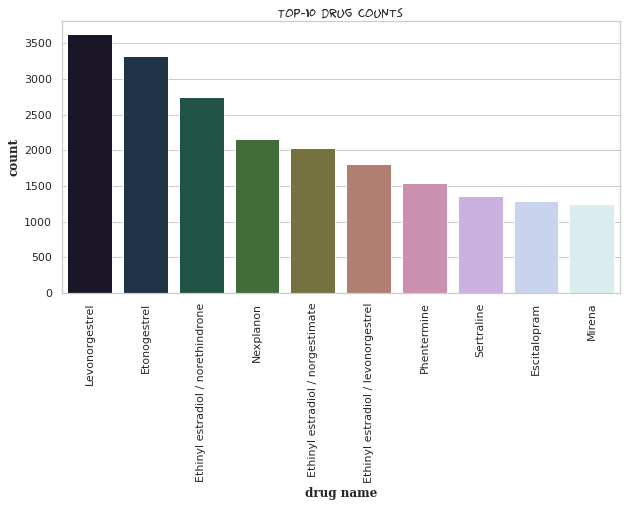

In [ ]:
#counts of top 10 drugs
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="drugName", y="count", data=top_10_drugs_df, palette=sns.color_palette("cubehelix", 10))
plt.xticks(rotation=90)
plt.title("Top-10 drug counts", {"fontname":"fantasy", "fontweight":"bold", "fontsize":"medium"})
plt.ylabel("count", {"fontname": "serif", "fontweight":"bold"})
plt.xlabel("drug name", {"fontname": "serif", "fontweight":"bold"})

In [ ]:
#ratings of top-10 drugs 
rating_top_10_df=data.loc[data["drugName"].isin(top_10_drugs.index), :]
rating_top_10_df

,uniqueID,drugName,condition,review,rating,date,usefulCount
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1
14,98494,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,7-Aug-14,10
22,227020,Etonogestrel,Birth Control,"""Nexplanon does its job. I can have worry free...",9,11-Aug-14,11
31,96233,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8,7-May-11,3
...,...,...,...,...,...,...,...
161262,144132,Etonogestrel,Birth Control,"""I got on the Nexplanon the same day I had my ...",3,20-Jun-16,7
161264,143487,Etonogestrel,Birth Control,"""Honestly, this was the worst birth control I ...",3,31-Jan-17,5
161269,73058,Ethinyl estradiol / norethindrone,Birth Control,"""When I first starting taking Lo Loestrin Fe, ...",10,20-Apr-15,13
161271,148859,Mirena,Birth Control,"""My experience: Painful insertion but I expect...",10,26-Jan-16,4


Text(0.5, 0, 'drug name')

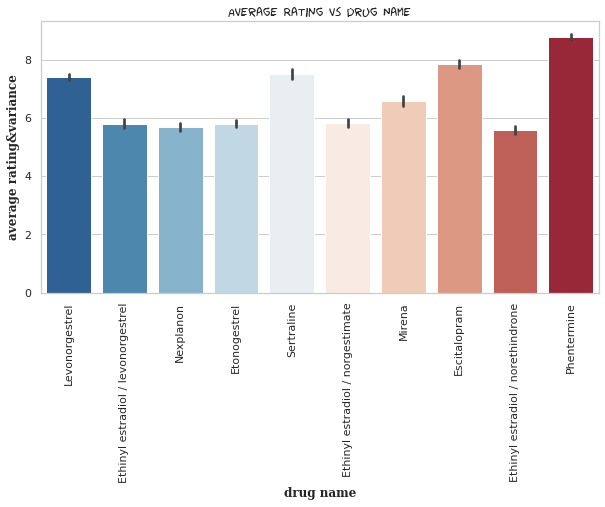

In [ ]:
#ratings(average-variance) of top-10 drugs
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="drugName", y="rating", data=rating_top_10_df, palette=sns.color_palette("RdBu_r", 10))
plt.xticks(rotation=90)
plt.title("Average Rating vs Drug Name", {"fontname":"fantasy", "fontweight":"bold", "fontsize":"medium"})
plt.ylabel("average rating&variance", {"fontname": "serif", "fontweight":"bold"})
plt.xlabel("drug name", {"fontname": "serif", "fontweight":"bold"})

In [ ]:
top_10_condition=data["condition"].value_counts().sort_values(ascending=False)[:10]

top_10_condition_df=pd.DataFrame(zip(top_10_condition.index, top_10_condition), columns = ["condition", "count"])

In [ ]:
top_10_condition_df

,condition,count
0,Birth Control,28788
1,Depression,9069
2,Pain,6145
3,Anxiety,5904
4,Acne,5588
5,Bipolar Disorde,4224
6,Insomnia,3673
7,Weight Loss,3609
8,Obesity,3568
9,ADHD,3383


Text(0.5, 0, 'condition')

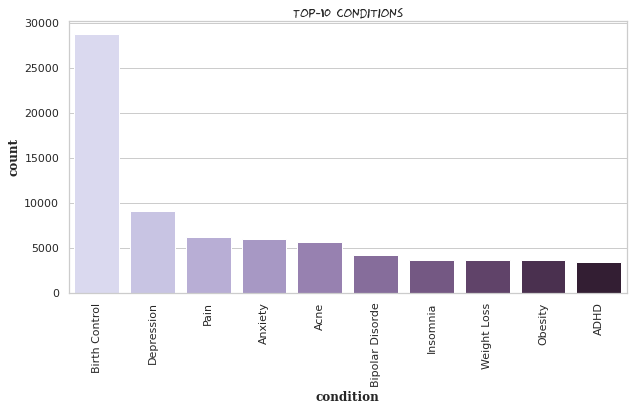

In [ ]:
#counts of top-10 conditions

sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="condition", y="count", data=top_10_condition_df, palette=sns.cubehelix_palette(10, start=.5, rot=-.20))
plt.xticks(rotation=90)
plt.title("Top-10 conditions", {"fontname":"fantasy", "fontweight":"bold", "fontsize":"medium"})
plt.ylabel("count", {"fontname": "serif", "fontweight":"bold"})
plt.xlabel("condition", {"fontname": "serif", "fontweight":"bold"})

Text(0.5, 0, 'rating')

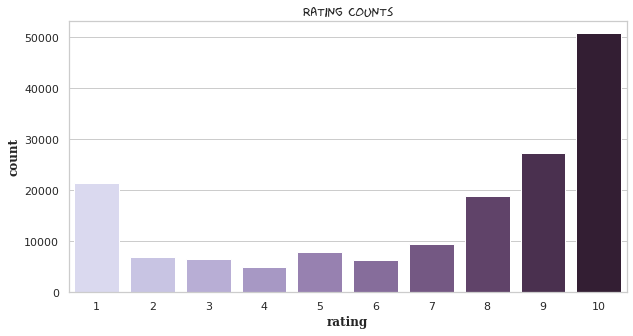

In [ ]:
#count of ratings 

sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="rating", data=data, palette=sns.cubehelix_palette(10, start=.5, rot=-.20))
plt.title("Rating counts", {"fontname":"fantasy", "fontweight":"bold", "fontsize":"medium"})
plt.ylabel("count", {"fontname": "serif", "fontweight":"bold"})
plt.xlabel("rating", {"fontname": "serif", "fontweight":"bold"})

In [ ]:
#conditions of top-1000 review(according to the "usefulCount" values)

top_100_reviews=data["usefulCount"].sort_values(ascending=False)[:100]
top_100_reviews_df=data.loc[top_100_reviews.index, :]

In [ ]:
print(top_100_reviews_df["usefulCount"].max())
print(top_100_reviews_df["usefulCount"].min())

1291
360


Text(0.5, 0, 'condition')

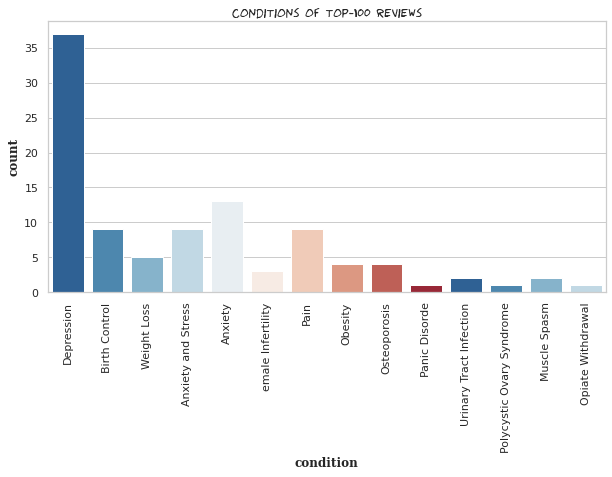

In [ ]:
#conditions of most useful(popular) reviews 

sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="condition", data=top_100_reviews_df, palette=sns.color_palette("RdBu_r", 10))
plt.xticks(rotation=90)
plt.title("Conditions of top-100 reviews", {"fontname":"fantasy", "fontweight":"bold", "fontsize":"medium"})
plt.ylabel("count", {"fontname": "serif", "fontweight":"bold"})
plt.xlabel("condition", {"fontname": "serif", "fontweight":"bold"})

In [ ]:
#create a new feature review_length
data["review_length"]= data["review"].str.len()


Text(0.5, 1.0, 'review length distribution')

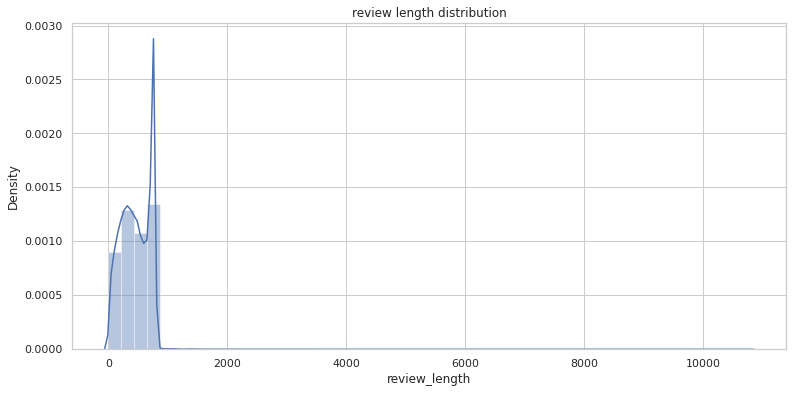

In [ ]:
#density of the review length
plt.figure(figsize=(12.8,6))
sns.distplot(data['review_length']).set_title('review length distribution')

Text(0.5, 1.0, 'review length distribution')

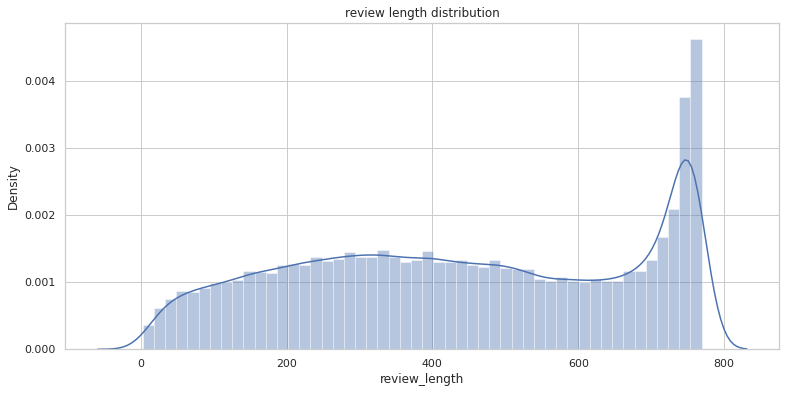

In [ ]:
quantile_95 = data['review_length'].quantile(0.95)
df_95 = data[data['review_length'] < quantile_95]

plt.figure(figsize=(12.8,6))
sns.distplot(df_95['review_length']).set_title('review length distribution')

In [ ]:
quantile_95

770.0

In [ ]:
df_more10k = data[data['review_length'] > 10000]
print(len(df_more10k))
print("-------")
print(df_more10k["review"].values)

1
-------
['"Two and a half months ago I was prescribed Venlafaxine to help prevent chronic migraines.\r\nIt did help the migraines (reduced them by almost half), but with it came a host of side effects that were far worse than the problem I was trying to get rid of.\r\nHaving now come off of the stuff, I would not recommend anyone ever use Venlafaxine unless they suffer from extreme / suicidal depression. I mean extreme in the most emphatic sense of the word. \r\nBefore trying Venlafaxine, I was a writer. While on Venlafaxine, I could barely write or speak or communicate at all. More than that, I just didn&#039;t want to. Not normal for a usually outgoing extrovert.\r\nNow, I&#039;m beginning to write again - but my ability to speak and converse with others has deteriorated by about 95%. Writing these words is taking forever; keeping up in conversation with even one person is impossible, and I barely see the point of trying either. On Venlafaxine, words pretty much left me - my conver

Text(0.5, 0, 'condition')

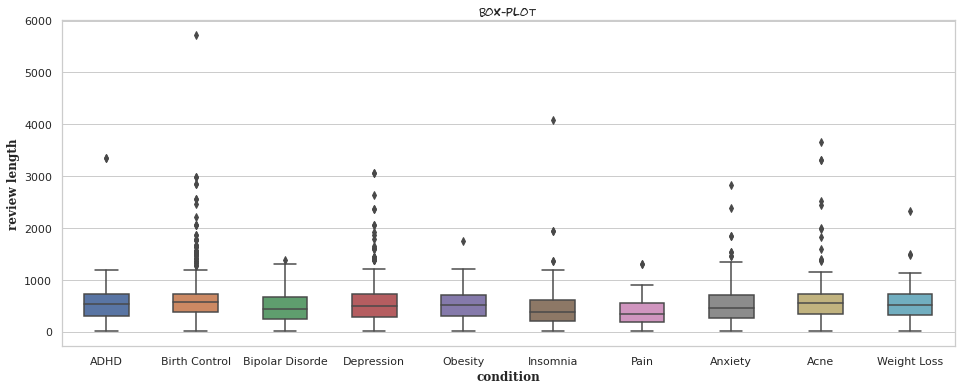

In [ ]:
#box-plot

top_10=data["condition"].value_counts().sort_values(ascending=False)[:10]
top_10_df=data.loc[data["condition"].isin(top_10.index), :]

plt.figure(figsize=(16,6))
sns.boxplot(data=top_10_df, x='condition', y='review_length', width=.5)
plt.title("Box-plot", {"fontname":"fantasy", "fontweight":"bold", "fontsize":"medium"})
plt.ylabel("review length", {"fontname": "serif", "fontweight":"bold"})
plt.xlabel("condition", {"fontname": "serif", "fontweight":"bold"})


Text(0.5, 0, 'condition')

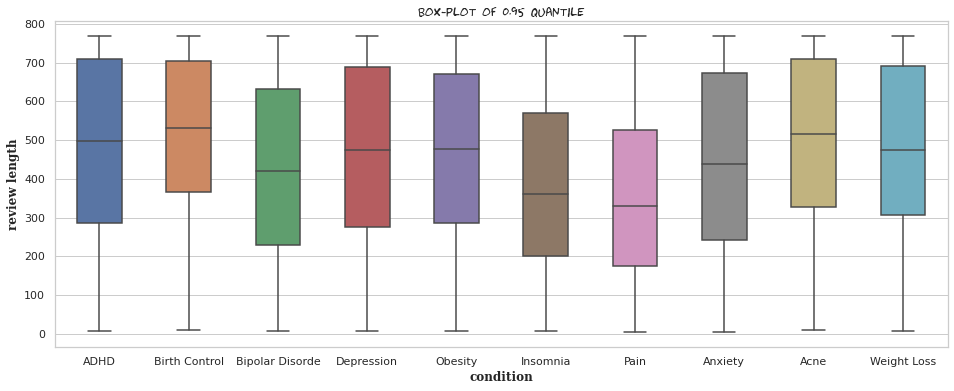

In [ ]:
#box-plot

top_10_version2=df_95["condition"].value_counts().sort_values(ascending=False)[:10]
top_10_version2_df=df_95.loc[df_95["condition"].isin(top_10.index), :]

plt.figure(figsize=(16,6))
sns.boxplot(data=top_10_version2_df, x='condition', y='review_length', width=.5)
plt.title("Box-plot of 0.95 quantile", {"fontname":"fantasy", "fontweight":"bold", "fontsize":"medium"})
plt.ylabel("review length", {"fontname": "serif", "fontweight":"bold"})
plt.xlabel("condition", {"fontname": "serif", "fontweight":"bold"})

In [ ]:
top_10_condition=data["condition"].value_counts().sort_values(ascending=False)[:10]
top_10_condition_df=data.loc[data["condition"].isin(top_10_condition.index), :]
len(top_10_condition_df)

73951

In [ ]:
top_10_condition_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_length
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,741
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,755
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,448
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32,733
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1,737


In [ ]:
top_10_condition_df['condition'].value_counts()

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64

In [ ]:
from sklearn.utils import resample
df_min_10 = top_10_condition_df[top_10_condition_df['condition']=='Birth Control']
df_min_1 = top_10_condition_df[top_10_condition_df['condition']=='Depression']
df_min_2 = top_10_condition_df[top_10_condition_df['condition']=='Pain']
df_min_3 = top_10_condition_df[top_10_condition_df['condition']=='Anxiety']
df_min_4 = top_10_condition_df[top_10_condition_df['condition']=='Acne']
df_min_5 = top_10_condition_df[top_10_condition_df['condition']=='Bipolar Disorde']
df_min_6 = top_10_condition_df[top_10_condition_df['condition']=='Insomnia']
df_min_7 = top_10_condition_df[top_10_condition_df['condition']=='Weight Loss']
df_min_8 = top_10_condition_df[top_10_condition_df['condition']=='Obesity']
df_min_9 = top_10_condition_df[top_10_condition_df['condition']=='ADHD']
 
df_1= resample(df_min_1,replace = False, n_samples = 2000)
df_2 = resample(df_min_2,replace = False, n_samples = 2000)
df_3 = resample(df_min_3,replace = False, n_samples = 2000)
df_4= resample(df_min_4,replace = False, n_samples = 2000)
df_5= resample(df_min_5,replace = False, n_samples = 2000)
df_6= resample(df_min_6,replace = False, n_samples = 2000)
df_7= resample(df_min_7,replace = False, n_samples = 2000)
df_8= resample(df_min_8,replace = False, n_samples = 2000)
df_9= resample(df_min_9,replace = False, n_samples = 2000)
df_10= resample(df_min_10,replace = False, n_samples = 2000)


 
data_final = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10],axis = 0)

In [ ]:
data_final.shape

(20000, 8)

In [ ]:
data_final['condition'].value_counts()

Obesity            2000
Birth Control      2000
Insomnia           2000
Pain               2000
Depression         2000
ADHD               2000
Weight Loss        2000
Bipolar Disorde    2000
Anxiety            2000
Acne               2000
Name: condition, dtype: int64

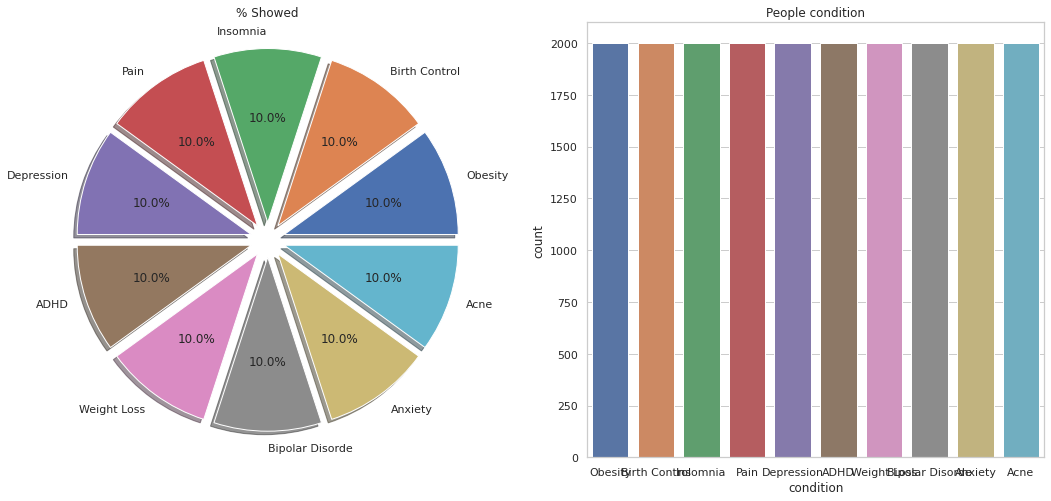

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data_final['condition'].value_counts().plot.pie(explode=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('% Showed')
ax[0].set_ylabel('')
sns.countplot('condition', order = data_final['condition'].value_counts().index, data=data_final,ax=ax[1])
ax[1].set_title('People condition')
plt.show()

In [ ]:
final_data = data_final.sample(frac=1)

In [ ]:
final_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_length
150555,66744,Seroquel,Bipolar Disorde,"""Helps you stable and calm""",10,4-Jun-14,54,27
23333,138803,Phentermine,Weight Loss,"""Overall, I think phentermine works great as a...",7,6-Jul-10,23,575
161229,93718,Morphine,Pain,"""I was diagnosed with a rare form of Lupus (as...",9,6-Jun-09,22,675
129411,173369,Alli,Obesity,"""I lost 75 pounds when I used Alli. I ate low ...",9,5-Aug-16,124,772
22973,13396,Amphetamine / dextroamphetamine,ADHD,"""I absolutely love Addreall. It helps me to co...",10,23-Jul-15,76,750
31936,13426,Amphetamine / dextroamphetamine,ADHD,"""It works but I think it might be the effect f...",7,27-Aug-14,90,192
148518,77318,Lorcaserin,Weight Loss,"""If there is such a thing as a &quot;Miracle P...",10,26-Jan-14,82,754
37243,20604,Nucynta,Pain,"""Gave me severe-headache,insomnia, dizzy, conf...",1,21-Nov-15,53,133
12711,83214,Paxil,Anxiety,"""I&#039;ve been diagnosed with generalized anx...",5,21-Nov-11,20,617
9094,37738,Vyvanse,ADHD,"""I am 45 and was diagnosed with ADD &amp; dysl...",10,29-Apr-08,27,319


In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
final_data['review'].head(5)

150555                          "Helps you stable and calm"
23333     "Overall, I think phentermine works great as a...
161229    "I was diagnosed with a rare form of Lupus (as...
129411    "I lost 75 pounds when I used Alli. I ate low ...
22973     "I absolutely love Addreall. It helps me to co...
Name: review, dtype: object

In [ ]:
print("printing some random reviews")
print(9, final_data['review'].values[9])
print(34, final_data['review'].values[34])
print(147, final_data['review'].values[147])

printing some random reviews
9 "I am 45 and was diagnosed with ADD &amp; dyslexia when i was a child. Didn&#039;t know about it until i was 40. Tried many other meds and would  highly recommend Vyvanse. The best part is not having the nervous-jittery feeling. I don&#039;t realize I am on it during the day. I am glad my doctor recommended it to me."
34 "Does help some. Not like stimulants but will keep you awake and have the energy."
147 "First of let me say that I was only able to take the sample pen of SAXENDA because it was too expensive and my insurance, BCBSIL and express scripts, only covered  $150 of the total $1300 plus that it cost.  But I will say that in those 3.5 weeks I lost 16lbs.  It did give me headaches and really bad heartburn.  My appetite was gone and I had no urge to snack on junk food.  between meals, small meals, I would eat a handful of peanuts or a tangerine or small apple and would be completetly good.  I did not workout.  Couldn&#039;t really due to fatigue wh

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [ ]:
preprocessed_text = preprocess_text(final_data['review'].values)

100%|██████████| 20000/20000 [00:04<00:00, 4924.61it/s]


In [ ]:
print("printing some random reviews")
print(9, preprocessed_text[9])
print(34, preprocessed_text[34])
print(147, preprocessed_text[147])

printing some random reviews
9 45 diagnosed add amp dyslexia child 039 know 40 tried many meds would highly recommend vyvanse best part not nervous jittery feeling 039 realize day glad doctor recommended
34 help not like stimulants keep awake energy
147 first let say able take sample pen saxenda expensive insurance bcbsil express scripts covered 150 total 1300 plus cost say 3 5 weeks lost 16lbs give headaches really bad heartburn appetite gone no urge snack junk food meals small meals would eat handful peanuts tangerine small apple would completetly good not workout 039 really due fatigue also issue 039 eat enough day though would end eating bad night must eat eat healthy tums pepto fiber best friends


In [ ]:
y = final_data['condition']

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
y = np.array(y)

In [ ]:
y[:5]

array([3, 9, 8, 7, 0])

In [ ]:
from sklearn.model_selection import train_test_split
#Breaking into Train and test

X_train, X_test, y_train, y_test = train_test_split(preprocessed_text, y, test_size=0.3,stratify=y ,random_state=42)

## Featuraization : Bag of Words

In [ ]:
import pickle

In [ ]:
from sklearn import preprocessing

count_vect = CountVectorizer(max_features = 5000)
count_trans = count_vect.fit(X_train) # fit has to happen only on train data

# Dump the file
pickle.dump(count_trans, open("/content/drive/MyDrive/Drug_side_effects/count_vect.pkl", "wb"))


# Testing phase
count = pickle.load(open("/content/drive/MyDrive/Drug_side_effects/count_vect.pkl", 'rb'))

# we use the fitted CountVectorizer to convert the text to vector
X_train_count =count.transform(X_train)
X_test_count = count.transform(X_test)

#Normalize Data
X_train_count = preprocessing.normalize(X_train_count)
print("Train Data Size: ",X_train_count.shape)

#Normalize Data
X_test_count = preprocessing.normalize(X_test_count)
print("Test Data Size: ",X_test_count.shape)



Train Data Size:  (14000, 5000)
Test Data Size:  (6000, 5000)


## Featuraization:- TF-IDF

In [ ]:
from sklearn import preprocessing

tfidf = TfidfVectorizer(ngram_range=(1,2),max_features = 5000 )
tfidf_trans= tfidf.fit(X_train) # fit has to happen only on train data

# Dump the file
pickle.dump(tfidf_trans, open("/content/drive/MyDrive/Drug_side_effects/tfidf_vect.pkl", "wb"))


# Testing phase
tfidf = pickle.load(open("/content/drive/MyDrive/Drug_side_effects/tfidf_vect.pkl", 'rb'))

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf =tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#Normalize Data
X_train_tfidf = preprocessing.normalize(X_train_tfidf)
print("Train Data Size: ",X_train_tfidf.shape)

#Normalize Data
X_test_tfidf = preprocessing.normalize(X_test_tfidf)
print("Test Data Size: ",X_test_tfidf.shape)

Train Data Size:  (14000, 5000)
Test Data Size:  (6000, 5000)


## Logistic Regression with BOW

In [ ]:
import warnings
warnings.filterwarnings("ignore")

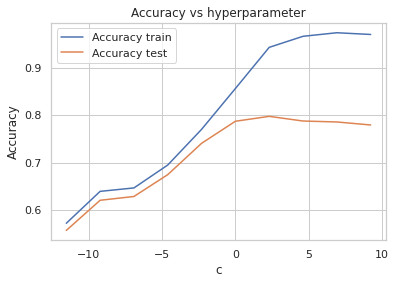

optimal c for which auc is maximum :  10


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import math

c = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

train_auc = []
test_auc = []

for i in c:
    log = LogisticRegression(penalty='l2',C=i)
    log.fit(X_train_count,y_train)
    prob_test = log.predict(X_test_count)
    test_auc.append(accuracy_score(y_test,prob_test))
    prob_train = log.predict(X_train_count)
    train_auc.append(accuracy_score(y_train,prob_train))
optimal_c= c[test_auc.index(max(test_auc))]
c = [math.log(x) for x in c]

#plot accuracy vs alpha
x = plt.subplot( )
x.plot(c, train_auc, label='Accuracy train')
x.plot(c, test_auc, label='Accuracy test')
plt.title('Accuracy vs hyperparameter')
plt.xlabel('c')
plt.ylabel('Accuracy')
x.legend()
plt.show()

print('optimal c for which auc is maximum : ',optimal_c)

Accuracy on Test data is 0.7973333333333333
Accuracy on Train data is 0.9427142857142857
---------------------------


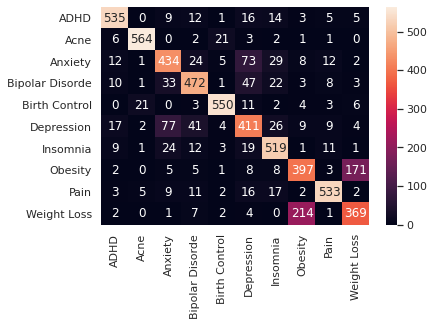

In [ ]:
#Testing AUC on Test data
log = LogisticRegression(penalty='l2',C=optimal_c)
log.fit(X_train_count,y_train)

filename = '/content/drive/MyDrive/Drug_side_effects/drug_log_bow_text.pkl'
pickle.dump(log, open(filename, 'wb'))

pred_test =log.predict(X_test_count)
test_accuracy = accuracy_score(y_test, pred_test)
pred_train = log.predict(X_train_count)
train_accuracy =accuracy_score(y_train,pred_train) 




print("Accuracy on Test data is " +str(accuracy_score(y_test,pred_test)))
print("Accuracy on Train data is " +str(accuracy_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
from sklearn.metrics import confusion_matrix
class_names = le.classes_
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [ ]:
original = []
for i in y_test[:20]:
  original.append(class_names[i])

predicted = log.predict(X_test_count[:20])
pred = []
for j in predicted:
  pred.append(class_names[j])



# Creating a data frame
df = pd.DataFrame(list(zip(X_test[:20],original, pred,)), 
               columns =['Text','original_Classlabel', 'predicted_classlebel'])
df

,Text,original_Classlabel,predicted_classlebel
0,amazing experience accutane completely book no...,Acne,Acne
1,2004 diagnosed adult onset still 039 disease 2...,Pain,Pain
2,going divorce miscarriage loss important job p...,Anxiety,Obesity
3,since taking belviq 1 month 039 lost 14 lbs cr...,Weight Loss,Obesity
4,trying fall asleep 20 minutes said ohh crap fo...,ADHD,Insomnia
5,one week 150xl dry mouth lost voice insomnia a...,Depression,Depression
6,first day q far seems effective controlling in...,Weight Loss,Obesity
7,bi polar awaken many times around 2 3 racing t...,Insomnia,Insomnia
8,serious worry wort comes periods pregnancy las...,Birth Control,Birth Control
9,took one year battled weight proplems years wi...,Weight Loss,Weight Loss


In [ ]:
X_test[:20]

['amazing experience accutane completely book no alcohol no unprotected sun exposure no unprotected intercourse healthy diet exercise lot due diligence 039 going go medicine need ready give normal routines order truly get best results 039 not willing give things 039 not ready accutane prepared difficulty bowel movements towards end treatment quite painful cause small hemorrhages go away treatment stopped things considered would absolutely recommend anyone 100 ready start treatment',
 '2004 diagnosed adult onset still 039 disease 2006 pain shot uncontrolled percocet 10 325mg every 6 hours doctor decided put god send well although unable work due fact employers view drug drug free workplace well maintained continue take tried last fall 60mg sedating caused migraines flare side effects constipation',
 'going divorce miscarriage loss important job plus career change breaking physically well mentally hospitalized testing observation cardiologist diagnosed hypothyroidism prescribed triavil a

In [ ]:
results=pd.DataFrame(columns=['Featuraization', 'Model' , 'Train-Accuracy', 'Test-Accuracy' ])
new = ['BOW','Logistic Regression',0.9427,0.7973]
results.loc[0] = new

## Random Forest with BOW

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

dept = [1, 5, 10, 50, 100, 500, 1000]
n_estimators =  [20, 40, 60, 80, 100, 120]

param_grid={'n_estimators':n_estimators , 'max_depth':dept}
clf = RandomForestClassifier()
model = GridSearchCV(clf,param_grid,scoring='accuracy',n_jobs=-1,cv=3)
model.fit(X_train_count,y_train)
print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

optimal n_estimators 120
optimal max_depth 100


In [ ]:
optimal_max_depth = model.best_estimator_.max_depth
optimal_n_estimators = model.best_estimator_.n_estimators

Accuracy on Test data is 0.7983333333333333
Accuracy on Train data is 0.9936428571428572
---------------------------


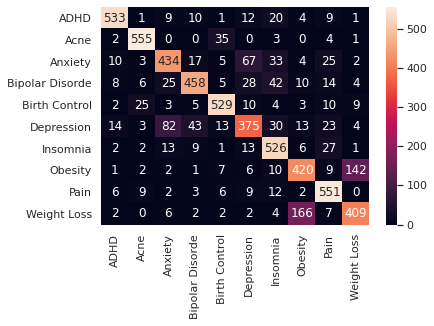

In [ ]:
#training our model for max_depth=100,n_estimators = 120
clf = RandomForestClassifier(max_depth = optimal_max_depth,n_estimators = optimal_n_estimators)
clf.fit(X_train_count,y_train)

import pickle
filename = '/content/drive/MyDrive/Drug_side_effects/drug_rf_bow_text.pkl'
pickle.dump(clf, open(filename, 'wb'))

pred_test =clf.predict(X_test_count)
test_accuracy = accuracy_score(y_test, pred_test)
pred_train = clf.predict(X_train_count)
train_accuracy =accuracy_score(y_train,pred_train)



print("Accuracy on Test data is " +str(test_accuracy))
print("Accuracy on Train data is "+str(train_accuracy))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = le.classes_
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [ ]:
original = []
for i in y_test[:20]:
  original.append(class_names[i])

predicted = clf.predict(X_test_count[:20])
pred = []
for j in predicted:
  pred.append(class_names[j])



# Creating a data frame
df = pd.DataFrame(list(zip(X_test[:20],original, pred,)), 
               columns =['Text','original_Classlabel', 'predicted_classlebel'])
df

,Text,original_Classlabel,predicted_classlebel
0,amazing experience accutane completely book no...,Acne,Acne
1,2004 diagnosed adult onset still 039 disease 2...,Pain,Pain
2,going divorce miscarriage loss important job p...,Anxiety,Obesity
3,since taking belviq 1 month 039 lost 14 lbs cr...,Weight Loss,Weight Loss
4,trying fall asleep 20 minutes said ohh crap fo...,ADHD,Insomnia
5,one week 150xl dry mouth lost voice insomnia a...,Depression,Depression
6,first day q far seems effective controlling in...,Weight Loss,Obesity
7,bi polar awaken many times around 2 3 racing t...,Insomnia,Insomnia
8,serious worry wort comes periods pregnancy las...,Birth Control,Birth Control
9,took one year battled weight proplems years wi...,Weight Loss,Obesity


In [ ]:

new = ['BOW','Random Forest',0.9801,0.7983]
results.loc[1] = new

## Liner SVM with BOW

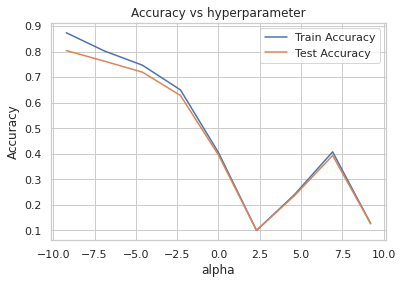

optimal alpha for which auc is maximum :  0.0001


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import math

alpha = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

train_auc = []
test_auc = []

for i in alpha:
    model = SGDClassifier(alpha=i, loss = "hinge") 
    model.fit(X_train_count,y_train)
    prob_cv = model.predict(X_test_count)
    test_auc.append(accuracy_score(y_test,prob_cv))
    prob_train = model.predict(X_train_count)
    train_auc.append(accuracy_score(y_train,prob_train))
optimal_alpha= alpha[test_auc.index(max(test_auc))]
alpha=[math.log(x) for x in alpha]

#plot auc vs alpha
x = plt.subplot( )
x.plot(alpha, train_auc, label='Train Accuracy')
x.plot(alpha, test_auc, label='Test Accuracy')
plt.title('Accuracy vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_alpha)

Accuray on Test data is 0.8015
Accuray on Train data is 0.8748571428571429
---------------------------


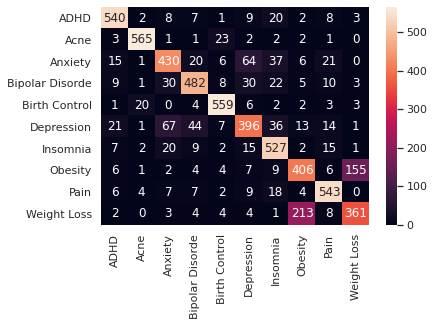

In [ ]:
#Testing AUC on Test data
svm = SGDClassifier(alpha=optimal_alpha)

svm.fit(X_train_count,y_train)

filename = '/content/drive/My Drive/Drug_side_effects/drug_svm_bow_text.pkl'
pickle.dump(svm, open(filename, 'wb'))

pred_test = svm.predict(X_test_count)
test_accuracy = accuracy_score(y_test, pred_test)
pred_train = svm.predict(X_train_count)
train_accuracy = accuracy_score(y_train,pred_train) 




print("Accuray on Test data is " +str(test_accuracy))
print("Accuray on Train data is " +str(train_accuracy))

print("---------------------------")

# Code for drawing seaborn heatmaps
from sklearn.metrics import confusion_matrix
class_names = le.classes_
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [ ]:
original = []
for i in y_test[:20]:
  original.append(class_names[i])

predicted = svm.predict(X_test_count[:20])
pred = []
for j in predicted:
  pred.append(class_names[j])



# Creating a data frame
df = pd.DataFrame(list(zip(X_test[:20],original, pred,)), 
               columns =['Text','original_Classlabel', 'predicted_classlebel'])
df

,Text,original_Classlabel,predicted_classlebel
0,amazing experience accutane completely book no...,Acne,Acne
1,2004 diagnosed adult onset still 039 disease 2...,Pain,Pain
2,going divorce miscarriage loss important job p...,Anxiety,ADHD
3,since taking belviq 1 month 039 lost 14 lbs cr...,Weight Loss,Weight Loss
4,trying fall asleep 20 minutes said ohh crap fo...,ADHD,Insomnia
5,one week 150xl dry mouth lost voice insomnia a...,Depression,Depression
6,first day q far seems effective controlling in...,Weight Loss,Obesity
7,bi polar awaken many times around 2 3 racing t...,Insomnia,Insomnia
8,serious worry wort comes periods pregnancy las...,Birth Control,Birth Control
9,took one year battled weight proplems years wi...,Weight Loss,Obesity


In [ ]:
new = ['BOW','Liner SVM',0.8748,0.8015]
results.loc[2] = new

## Random Forest with TF-IDF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

dept = [1, 5, 10, 50, 100, 500, 1000]
n_estimators =  [20, 40, 60, 80, 100, 120]

param_grid={'n_estimators':n_estimators , 'max_depth':dept}
clf = RandomForestClassifier()
model = GridSearchCV(clf,param_grid,scoring='accuracy',n_jobs=-1,cv=3)
model.fit(X_train_tfidf,y_train)
print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

optimal n_estimators 100
optimal max_depth 1000


In [ ]:
optimal_max_depth = model.best_estimator_.max_depth
optimal_n_estimators = model.best_estimator_.n_estimators

AUC on Test data is 0.7881666666666667
AUC on Train data is 0.9983571428571428
---------------------------


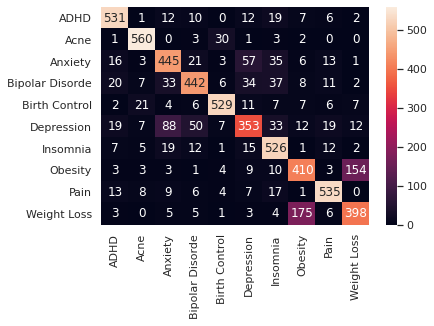

In [ ]:
#training our model for max_depth=100,n_estimators = 120
clf = RandomForestClassifier(max_depth = optimal_max_depth,n_estimators = optimal_n_estimators)
clf.fit(X_train_tfidf,y_train)

import pickle
filename = '/content/drive/My Drive/Drug_side_effects/drug_rf_tfidf_text.pkl'
pickle.dump(clf, open(filename, 'wb'))

pred_test =clf.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, pred_test)
pred_train = clf.predict(X_train_tfidf)
train_accuracy =accuracy_score(y_train,pred_train)



print("AUC on Test data is " +str(accuracy_score(y_test,pred_test)))
print("AUC on Train data is " +str(accuracy_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = le.classes_
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [ ]:
original = []
for i in y_test[:20]:
  original.append(class_names[i])

predicted = clf.predict(X_test_tfidf[:20])
pred = []
for j in predicted:
  pred.append(class_names[j])



# Creating a data frame
df = pd.DataFrame(list(zip(X_test[:20],original, pred,)), 
               columns =['Text','original_Classlabel', 'predicted_classlebel'])
df

,Text,original_Classlabel,predicted_classlebel
0,amazing experience accutane completely book no...,Acne,Acne
1,2004 diagnosed adult onset still 039 disease 2...,Pain,Pain
2,going divorce miscarriage loss important job p...,Anxiety,Obesity
3,since taking belviq 1 month 039 lost 14 lbs cr...,Weight Loss,Weight Loss
4,trying fall asleep 20 minutes said ohh crap fo...,ADHD,Insomnia
5,one week 150xl dry mouth lost voice insomnia a...,Depression,Depression
6,first day q far seems effective controlling in...,Weight Loss,Obesity
7,bi polar awaken many times around 2 3 racing t...,Insomnia,Insomnia
8,serious worry wort comes periods pregnancy las...,Birth Control,Birth Control
9,took one year battled weight proplems years wi...,Weight Loss,Obesity


In [ ]:
new = ['TF-IDF','Random Forest',0.9983,0.7983]
results.loc[3] = new

## Logistic Regression with TF-IDF

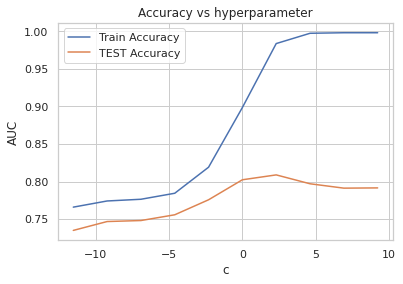

optimal c for which auc is maximum :  10


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import math

c = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

train_auc = []
test_auc = []

for i in c:
    log = LogisticRegression(penalty='l2',C=i)
    log.fit(X_train_tfidf,y_train)
    prob_test = log.predict(X_test_tfidf)
    test_auc.append(accuracy_score(y_test,prob_test))
    prob_train = log.predict(X_train_tfidf)
    train_auc.append(accuracy_score(y_train,prob_train))
optimal_c= c[test_auc.index(max(test_auc))]
c = [math.log(x) for x in c]

#plot auc vs alpha
x = plt.subplot( )
x.plot(c, train_auc, label='Train Accuracy')
x.plot(c, test_auc, label='TEST Accuracy')
plt.title('Accuracy vs hyperparameter')
plt.xlabel('c')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal c for which auc is maximum : ',optimal_c)

Accuracy on Test data is 0.8088333333333333
Accuracy on Train data is 0.9838571428571429
---------------------------


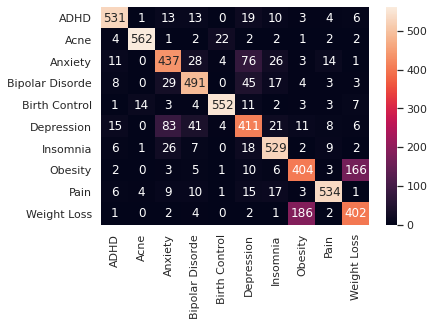

In [ ]:
#Testing AUC on Test data
log = LogisticRegression(penalty='l2',C=optimal_c)
log.fit(X_train_tfidf,y_train)

filename = '/content/drive/My Drive/Drug_side_effects/drug_log_tfidf_text.pkl'
pickle.dump(log, open(filename, 'wb'))

pred_test = log.predict(X_test_tfidf)
test_accuracy= accuracy_score(y_test, pred_test)
pred_train = log.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train,pred_train) 




print("Accuracy on Test data is " +str(accuracy_score(y_test,pred_test)))
print("Accuracy on Train data is " +str(accuracy_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
from sklearn.metrics import confusion_matrix
class_names = le.classes_
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [ ]:
original = []
for i in y_test[:20]:
  original.append(class_names[i])

predicted = log.predict(X_test_tfidf[:20])
pred = []
for j in predicted:
  pred.append(class_names[j])


# Creating a data frame
df = pd.DataFrame(list(zip(X_test[:20],original, pred,)), 
               columns =['Text','original_Classlabel', 'predicted_classlebel'])
df

,Text,original_Classlabel,predicted_classlebel
0,amazing experience accutane completely book no...,Acne,Acne
1,2004 diagnosed adult onset still 039 disease 2...,Pain,Pain
2,going divorce miscarriage loss important job p...,Anxiety,Depression
3,since taking belviq 1 month 039 lost 14 lbs cr...,Weight Loss,Weight Loss
4,trying fall asleep 20 minutes said ohh crap fo...,ADHD,Insomnia
5,one week 150xl dry mouth lost voice insomnia a...,Depression,Depression
6,first day q far seems effective controlling in...,Weight Loss,Obesity
7,bi polar awaken many times around 2 3 racing t...,Insomnia,Insomnia
8,serious worry wort comes periods pregnancy las...,Birth Control,Birth Control
9,took one year battled weight proplems years wi...,Weight Loss,Weight Loss


In [ ]:
new = ['TF-IDF','Logistic Regression',0.9838,0.8088]
results.loc[4] = new

## Liner SVM with TF-IDF

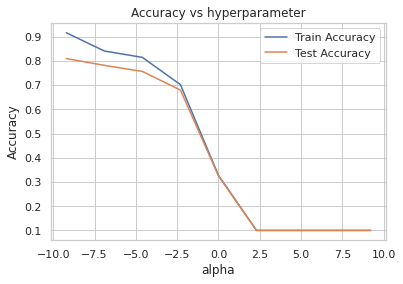

optimal alpha for which auc is maximum :  0.0001


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import math

alpha = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

train_auc = []
test_auc = []

for i in alpha:
    model = SGDClassifier(alpha=i, loss = "hinge") 
    
    model.fit(X_train_tfidf,y_train)
    prob_cv = model.predict(X_test_tfidf)
    test_auc.append(accuracy_score(y_test,prob_cv))
    prob_train = model.predict(X_train_tfidf)
    train_auc.append(accuracy_score(y_train,prob_train))
optimal_alpha= alpha[test_auc.index(max(test_auc))]
alpha=[math.log(x) for x in alpha]

#plot auc vs alpha
x = plt.subplot( )
x.plot(alpha, train_auc, label='Train Accuracy')
x.plot(alpha, test_auc, label='Test Accuracy')
plt.title('Accuracy vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_alpha)

Accuracy on Test data is 0.809
Accuracy on Train data is 0.9154285714285715
---------------------------


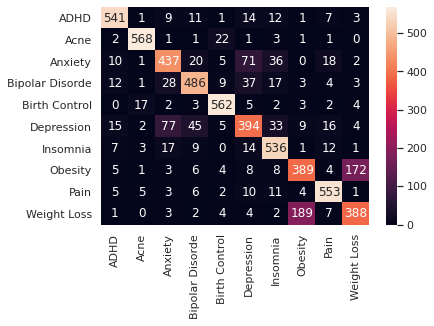

In [ ]:
#Testing AUC on Test data
svm = SGDClassifier(alpha=optimal_alpha)

svm.fit(X_train_tfidf,y_train)

filename = '/content/drive/My Drive/Drug_side_effects/drug_svm_tfidf_text.pkl'
pickle.dump(svm, open(filename, 'wb'))

pred_test = svm.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, pred_test)
pred_train = svm.predict(X_train_tfidf)
train_accuracy= accuracy_score(y_train,pred_train) 




print("Accuracy on Test data is " +str(accuracy_score(y_test,pred_test)))
print("Accuracy on Train data is " +str(accuracy_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
from sklearn.metrics import confusion_matrix
class_names = le.classes_
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [ ]:
original = []
for i in y_test[:20]:
  original.append(class_names[i])

predicted = svm.predict(X_test_tfidf[:20])
pred = []
for j in predicted:
  pred.append(class_names[j])


# Creating a data frame
df = pd.DataFrame(list(zip(X_test[:20],original, pred,)), 
               columns =['Text','original_Classlabel', 'predicted_classlebel'])
df

,Text,original_Classlabel,predicted_classlebel
0,amazing experience accutane completely book no...,Acne,Acne
1,2004 diagnosed adult onset still 039 disease 2...,Pain,Pain
2,going divorce miscarriage loss important job p...,Anxiety,ADHD
3,since taking belviq 1 month 039 lost 14 lbs cr...,Weight Loss,Weight Loss
4,trying fall asleep 20 minutes said ohh crap fo...,ADHD,Insomnia
5,one week 150xl dry mouth lost voice insomnia a...,Depression,Depression
6,first day q far seems effective controlling in...,Weight Loss,Obesity
7,bi polar awaken many times around 2 3 racing t...,Insomnia,Insomnia
8,serious worry wort comes periods pregnancy las...,Birth Control,Birth Control
9,took one year battled weight proplems years wi...,Weight Loss,Obesity


In [ ]:
new = ['TF-IDF','SVM',0.9154,0.809]
results.loc[5] = new

## Performance Table

In [ ]:
results

,Featuraization,Model,Train-Accuracy,Test-Accuracy
0,BOW,Logistic Regression,0.9427,0.7973
1,BOW,Random Forest,0.9801,0.7983
2,BOW,Liner SVM,0.8748,0.8015
3,TF-IDF,Random Forest,0.9983,0.7983
4,TF-IDF,Logistic Regression,0.9838,0.8088
5,TF-IDF,SVM,0.9154,0.8090
